In [ ]:
!pip install captum
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import captum
captum.__version__

'0.5.0'

In [ ]:
# import misc libraries
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# import torch modules
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms as T
from torchinfo import summary

print('torch:', torch.__version__)
print("torchvision:", torchvision.__version__)

# import captum modules
import captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

print('captum:', captum.__version__)

torch.manual_seed(0)
np.random.seed(0)

torch: 1.12.0+cu113
torchvision: 0.13.0+cu113
captum: 0.5.0


In [ ]:
idx_to_labels = [
    'NORMAL',
    'PNEUMONIA'
]

In [ ]:


def get_image(path:str)->Image.Image:
    return Image.open(path).convert('RGB').resize((224, 224))

img_path = '/content/drive/MyDrive/Pneumonia Classification/chest_xray/test/PNEUMONIA/person1946_bacteria_4874.jpeg'
assert os.path.exists(img_path)
img = get_image(img_path)

transform = T.Compose([
    T.Resize(224),
    T.ToTensor()
])

norm_cfg = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transform_normalize = T.Normalize(**norm_cfg)


transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [ ]:
def load_model(type='mobilenetv3', path='/content/drive/MyDrive/Pneumonia Classification/mobilenetv3_best_weights.pth'):
    assert os.path.exists(path), 'path does not exists'
    if type == 'mobilenetv3':
        model = models.mobilenet_v3_large()
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 2)
        model.load_state_dict(torch.load(path))
        return model

model = load_model()
summary(model, input.shape, depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           4,440
│    └─InvertedResidual: 2-5                       [1, 40, 28, 28]           10,328
│    └─InvertedResidual: 2-6                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-7                       [1, 40, 28, 28]           20,992
│    └─InvertedResidual: 2-8                       [1, 80, 14, 14]           32,080
│    └─InvertedResidual: 2-9                       [1, 80, 14, 14]           34,760
│    └─

In [ ]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print("prediction score:", prediction_score)
print("predicted label:", pred_label_idx, idx_to_labels[pred_label_idx])

# pred_label_idx.squeeze_()
# print(pred_label_idx)
# predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
# print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

prediction score: tensor([[0.9950]], grad_fn=<TopkBackward0>)
predicted label: tensor([[1]]) PNEUMONIA


## Gradient Based Attribution

In [ ]:
%%time
integrated_gradients = IntegratedGradients(model)

%time
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
CPU times: user 8.38 s, sys: 1.81 s, total: 10.2 s
Wall time: 5.11 s


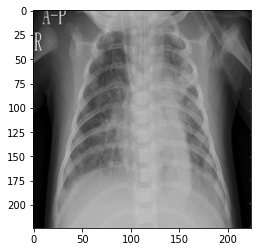

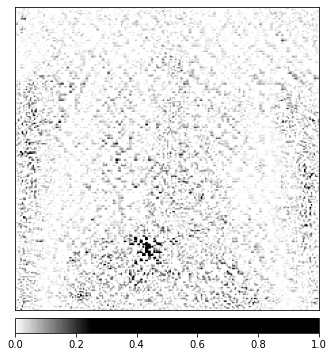

CPU times: user 707 ms, sys: 8.9 ms, total: 716 ms
Wall time: 741 ms


In [ ]:
%%time
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

plt.imshow(img)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
%%time
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig_nt = noise_tunnel.attribute(
    input, 
    nt_samples=10, 
    nt_type='smoothgrad_sq', 
    target=pred_label_idx
)

CPU times: user 1min 13s, sys: 2.71 s, total: 1min 16s
Wall time: 38.3 s


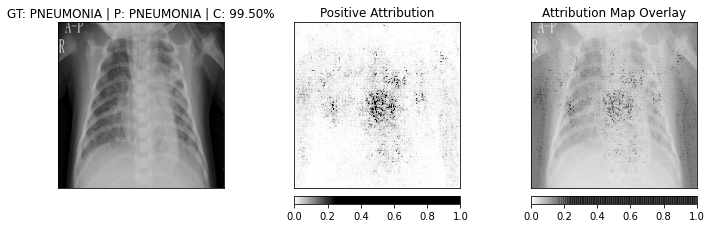

In [ ]:
PLOT = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map", 'blended_heat_map'],
    ["all", "positive", 'positive'],
    titles=[
        'GT: {} | P: {} | C: {:.2%}'.format(
            "NORMAL" if "NORMAL" in os.path.basename(img_path) else "PNEUMONIA", 
            idx_to_labels[pred_label_idx],
            prediction_score.detach().squeeze()
        ), 
        'Positive Attribution', 
        'Attribution Map Overlay'
    ],
    cmap=default_cmap,
    show_colorbar=True,
    fig_size=(10, 6)
)


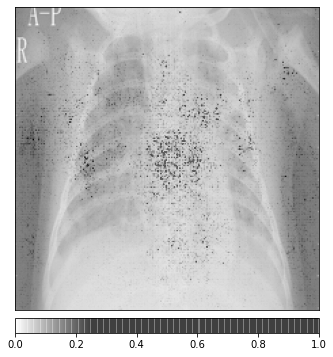

In [ ]:
PLOT = viz.visualize_image_attr(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    'blended_heat_map',
    cmap=default_cmap,
    show_colorbar=True
)

In [ ]:
# gradient_shap = GradientShap(model)

# # Defining baseline distribution of images
# rand_img_dist = torch.cat([input * 0, input * 1])

# attributions_gs = gradient_shap.attribute(input,
#                                           n_samples=50,
#                                           stdevs=0.0001,
#                                           baselines=rand_img_dist,
#                                           target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "absolute_value"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)

## Occlusion Based Attribution

In [ ]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(input,
#                                        strides = (3, 8, 8),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,15, 15),
#                                        baselines=0)

In [ ]:
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )

In [ ]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(input,
#                                        strides = (3, 50, 50),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,60, 60),
#                                        baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )